# Particle image classifier

You can open this notebook either within a supported container or Google colaboratory [here](https://colab.research.google.com/github/slaclab/slacml-school/blob/master/IntroNN/Pytorch-05-ParticleImageClassifier-Solution.ipynb).

In this notebook, we implement a simple CNN to see the effect of data normalization using the dataset for image classification challenge.

## Goals
* Design and traing a CNN without normalization
* Design and train a CNN with batch normalization


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

## Data access

* A data file with 400,000 images for training: `train.h5`
  * ... which include 100,000 images per particle type
* A data file with 100,000 images for testing: `test.h5`
  * ... which include 25,000 images per particle type

The commands below download the datafile (unless it already exists locally).

In [2]:
%%bash
if [ -f "train.h5" ]; then
    echo "data file already downloaded"
else 
    wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zSQjqn-9tM6rNyuRBvoAoc4YEXFHB0X8' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zSQjqn-9tM6rNyuRBvoAoc4YEXFHB0X8" -O test.h5 && rm -rf /tmp/cookies.txt;
    wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V8C51N19u1i7-h2UbDNE1F-t_ffDJlpt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V8C51N19u1i7-h2UbDNE1F-t_ffDJlpt" -O train.h5 && rm -rf /tmp/cookies.txt;
fi


--2021-12-14 09:39:51--  https://docs.google.com/uc?export=download&confirm=ToJx&id=1zSQjqn-9tM6rNyuRBvoAoc4YEXFHB0X8
Resolving docs.google.com (docs.google.com)... 142.251.46.206, 2607:f8b0:4005:80e::200e
Connecting to docs.google.com (docs.google.com)|142.251.46.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-98-docs.googleusercontent.com/docs/securesc/thv7p164kkcc4m9mh4c68kbtvhpemcqn/e24vlvjrh8ij87brkdubq1ho7tu3onge/1639503525000/07833402514977060033/01387744196647533268Z/1zSQjqn-9tM6rNyuRBvoAoc4YEXFHB0X8?e=download [following]
--2021-12-14 09:39:51--  https://doc-0g-98-docs.googleusercontent.com/docs/securesc/thv7p164kkcc4m9mh4c68kbtvhpemcqn/e24vlvjrh8ij87brkdubq1ho7tu3onge/1639503525000/07833402514977060033/01387744196647533268Z/1zSQjqn-9tM6rNyuRBvoAoc4YEXFHB0X8?e=download
Resolving doc-0g-98-docs.googleusercontent.com (doc-0g-98-docs.googleusercontent.com)... 142.251.46.225, 2607:f8b0:4005:807::2001
Connecting to doc-0

These files are `HDF5` files and can be opened using `h5py`. 

In [3]:
import h5py as h5
datapath='./train.h5'

# Open a file in 'r'ead mode.
f=h5.File(datapath,mode='r',swmr=True) 

# List items in the file
for key in f.keys():
    print('dataset',key,'... type',f[key].dtype,'... shape',f[key].shape)

dataset image ... type float32 ... shape (400000, 192, 192)
dataset index ... type int32 ... shape (400000,)
dataset mean ... type float64 ... shape (1,)
dataset pdg ... type int32 ... shape (400000,)
dataset std ... type float64 ... shape (1,)


... and let's visualize one image for fun!

PDG code 13


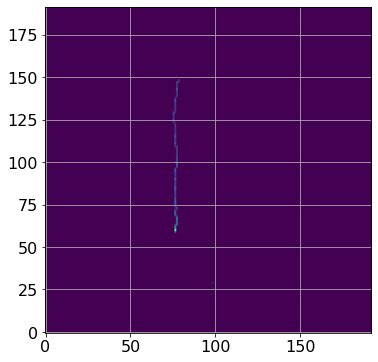

In [4]:
entry = 0

print('PDG code',f['pdg'][entry])
plt.imshow(f['image'][entry],origin='lower')
plt.show()

PDG code 13 means muon (if you are unfamiliar, "PDG code" is a signed integer as a unique identifier of a particle. See [this documentation](https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf) for more details.)

Let's don't forget to close the file :)

In [5]:
f.close()

### `Dataset` and `DataLoader`

We prepared a simple torch `Dataset` implementation for this dataset.

In [6]:
from utils import ParticleImage2D
train_data = ParticleImage2D(data_files=[datapath])

The dataset is index-accessible and produce a dictionary with four keys
* `data` ... 2D image of a particle (192x192 pixels)
* `pdg` ... PDG code of a particle. Should be [11,13,22,2212] = [electron,muon,photon,proton]
* `label` ... an integer label for classification
* `index` ... an index of the data entry from an input file

Size of dataset 400000
List of keys in a data element dict_keys(['data', 'label', 'pdg', 'index']) 

Again 0-th image! PDG code 13 ... label 1 



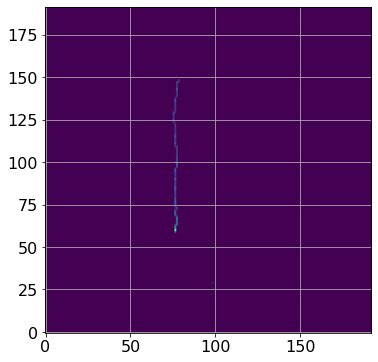

In [7]:
print('Size of dataset',len(train_data))

# Access the 0-th instance
data = train_data[0]

# The data instance is a dictionary
print('List of keys in a data element',data.keys(),'\n')

# Visualize the image
print('Again 0-th image! PDG code %d ... label %d \n' % (data['pdg'],data['label']))
plt.imshow(data['data'],origin='lower')
plt.show()

Create a `DataLoader` instance in a usual way except we give a specifically designed collate function to handle a dictionary style data instance.

In [8]:
train_data = ParticleImage2D(data_files = [datapath], start=0.0, end=0.5)

# We use a specifically designed "collate" function to create a batch data
from utils import collate
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 1,
                          batch_size  = 64
                         )


Let's measure the speed of the dataloader

In [9]:
import time
tstart=time.time()
num_iter=100
ctr=num_iter
for batch in train_loader:
    ctr -=100
    if ctr <= 0: break
print((time.time()-tstart)/num_iter,'[s/iteration]')

0.015917539596557617 [s/iteration]


## CNN without any normalization
Let's design a simple network for particle image classification. We stack convolution layers and x2 downsampling till the image size becomes 192x192 (input size) to 12x12. Then we apply a max-pooling to pick the largest activation over the whole 12x12 per feature. 


In [10]:
class CNN(torch.nn.Module):
    def __init__(self):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1,32,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32,32,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2,2),
            
            torch.nn.Conv2d(32,64,3,padding=1),
            torch.nn.LeakyReLU(),            
            torch.nn.Conv2d(64,64,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2,2),
            
            torch.nn.Conv2d(64,128,3,padding=1),
            torch.nn.LeakyReLU(),            
            torch.nn.Conv2d(128,128,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2,2),
            
            torch.nn.Conv2d(128,256,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(256,256,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2,2),
            
            torch.nn.Conv2d(256,512,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(512,512,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(12,12))
        # classifier MLP
        self._classifier = torch.nn.Linear(512,4)

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classifier
        return self._classifier(features)

In [11]:
from ipywidgets import IntProgress
from IPython.display import display
from torch.utils.tensorboard import SummaryWriter
import time

def run_train(model, loader,  
              num_iterations=100, log_dir='log',
              lr=0.001, optimizer='SGD', device=None):
    print("\nTraining...")
    tstart = time.time()
    if log_dir:
        writer = SummaryWriter(log_dir=log_dir)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = getattr(torch.optim,optimizer)(model.parameters(),lr=lr)
    f = IntProgress(min=0,max=int(num_iterations/100),bar_style='info')
    display(f)
    
    iteration = 0
    while iteration < num_iterations:
        for data,label in loader:
            
            if device:
                data,label = data.to(device),label.to(device)

            loss = criterion(model(data), label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if log_dir: 
                writer.add_scalar('loss/train', loss.item(), iteration)
            if iteration%100 == 0:
                f.value += 1
            # Brake if we consumed all iteration counts
            iteration += 1
            if iteration >= num_iterations:
                break
    print('done',time.time()-tstart,'[s]')


def run_test(model,loader,num_iterations=100,device=None):

    label_v, softmax_v = [],[]
    softmax = torch.nn.Softmax(dim=1)
    f = IntProgress(min=0,max=int(min([len(loader),num_iterations])),bar_style='info')
    display(f)
    
    with torch.set_grad_enabled(False):
        for data,label in loader:
            if device:
                data,label = data.to(device), label.to(device)
            label_v.append  ( label.detach().reshape(-1)   )
            softmax_v.append( softmax(model(data)).detach())
            f.value += 1
            num_iterations -= 1
            if num_iterations < 1:
                break
    return torch.concat(label_v).cpu().numpy(), torch.concat(softmax_v).cpu().numpy()


Train the network. We use a prepared `train_loop` function from `utils.py`. 

In [12]:
torch.manual_seed(123)

model=CNN().to(device)

run_train(model, train_loader, 1000, log_dir='particle_cnn/run00', optimizer='Adam', device=device)

torch.save(dict(model = model.state_dict()), 'model-A-1000.ckpt')


Training...


IntProgress(value=0, bar_style='info', max=10)

done 139.12816095352173 [s]


In [13]:
%load_ext tensorboard

%tensorboard --logdir particle_cnn

### Performance: classification accuracy

Let's run the network on a test dataset to see a classification performance. 

In [14]:
# For plotting a confusion matrix
from utils import plot_confusion_matrix, plot_softmax

test_data = ParticleImage2D(data_files=['./test.h5'])
test_loader = DataLoader(test_data,
                         collate_fn  = collate,
                         shuffle     = False,
                         num_workers = 2,
                         batch_size  = 64,
                        )

# For the Test set
labels, softmax = run_test(model,test_loader,device=device)


IntProgress(value=0, bar_style='info')

Accuracy mean 0.8140625 std 0.38905622484899277


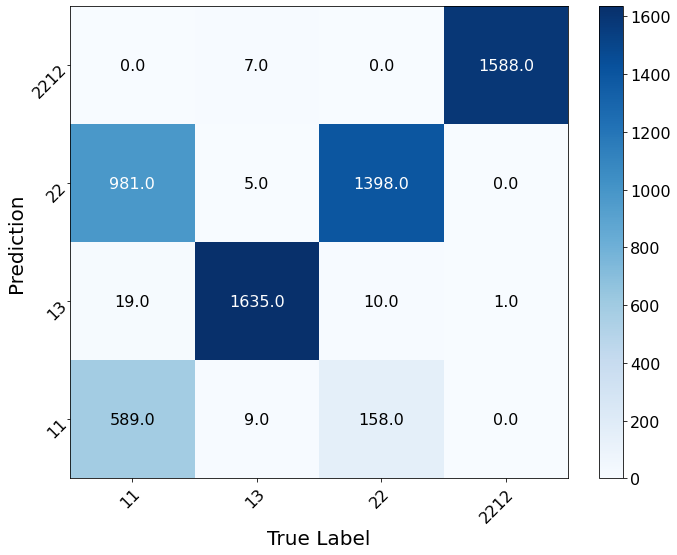

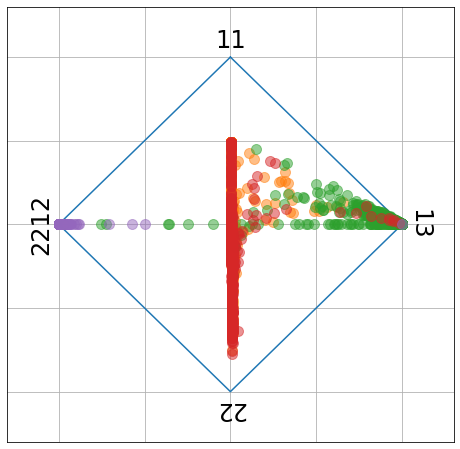

In [15]:
print('Accuracy mean',(np.argmax(softmax,axis=1)==labels).astype(np.float).mean(),
      'std',(np.argmax(softmax,axis=1)==labels).astype(np.float).std())
plot_confusion_matrix(labels,np.argmax(softmax,axis=1),test_data.classes)
plot_softmax(labels,softmax,test_data.classes)

## Saving & Restoring the weights

Training could take time, and it would be handy to be able to "store the trained network parameters" in a file. This can be easily done in any ML libraries including pytorch, and, in fact, we already stored. You should be seeing `model-A-1000.ckpt` in your file browser. 

Let's exercise how to restore the weights. We first re-create our network.


In [16]:
model = CNN().to(device)

If we run an inference, this should yield a bad result = accuracy at aroudn 25% (i.e. a random guess among 4 target classes)

In [17]:
labels, softmax = run_test(model,test_loader,100,device=device)
print('average accuracy',np.mean(labels==np.argmax(softmax,axis=1)))

IntProgress(value=0, bar_style='info')

average accuracy 0.25875


Let's load the weights using `torch.load` function. 

In [18]:
with open('model-A-1000.ckpt', 'rb') as f:
    checkpoint = torch.load(f)
    model.load_state_dict(checkpoint['model'], strict=False)

Now run again the inference...

In [19]:
labels, softmax = run_test(model,test_loader,100,device=device)
print('average accuracy',np.mean(labels==np.argmax(softmax,axis=1)))

IntProgress(value=0, bar_style='info')

average accuracy 0.8140625


_Voila!_

## CNN with batch normalization

### Exercise 1
Modify the CNN used in the above exercise and add a `Batch Normalization` layer after every convolution layer.

In [20]:
class CNN(torch.nn.Module):
    def __init__(self):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.BatchNorm2d(1),            
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(1,32,3,padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32,32,3,padding=1),
            torch.nn.MaxPool2d(2,2),
        
            torch.nn.BatchNorm2d(32),            
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32,64,3,padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64,64,3,padding=1),
            torch.nn.MaxPool2d(2,2),
            
            torch.nn.BatchNorm2d(64),            
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64,128,3,padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128,128,3,padding=1),
            torch.nn.MaxPool2d(2,2),

            torch.nn.BatchNorm2d(128),            
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128,256,3,padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(256,256,3,padding=1),
            torch.nn.MaxPool2d(2,2),

            torch.nn.BatchNorm2d(256),            
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(256,512,3,padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(512,512,3,padding=1),
            torch.nn.MaxPool2d(12,12))
            
        # classifier MLP
        self._classifier = torch.nn.Linear(512,4)

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classifier
        return self._classifier(features)

### Exercise 2

Train your CNN and compare the loss curve against two loss curves obtained above in this notebook. Run the inference on the test dataset and produce the confusion matrix and softmax score visualization for the newly trained network.

In [21]:
train_data = ParticleImage2D(data_files=[datapath],start=0.,end=0.5)
train_loader = DataLoader(train_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 4,
                          batch_size  = 64,
                         )
torch.manual_seed(123)
model=CNN().to(device)

run_train(model, train_loader, 1000, log_dir='particle_cnn/run01', optimizer='Adam', device=device)

torch.save(dict(model = model.state_dict()), 'model-B-1000.ckpt')


Training...


IntProgress(value=0, bar_style='info', max=10)

done 158.55817294120789 [s]


IntProgress(value=0, bar_style='info')

Test set accuracy mean 0.8840625 std 0.32014995875956315


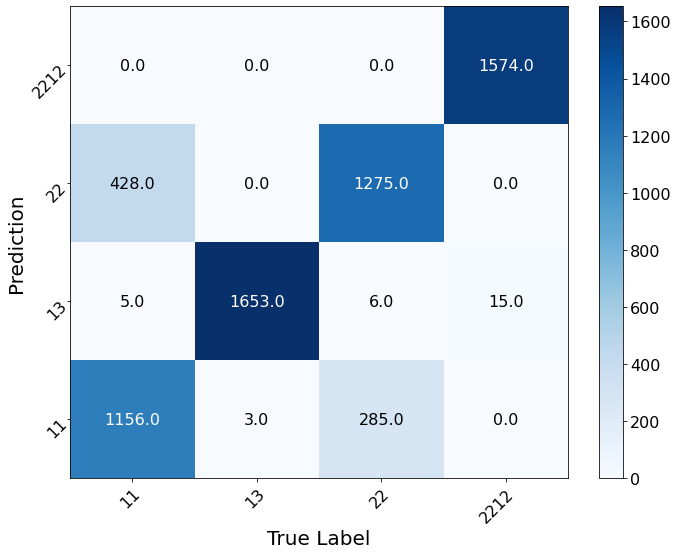

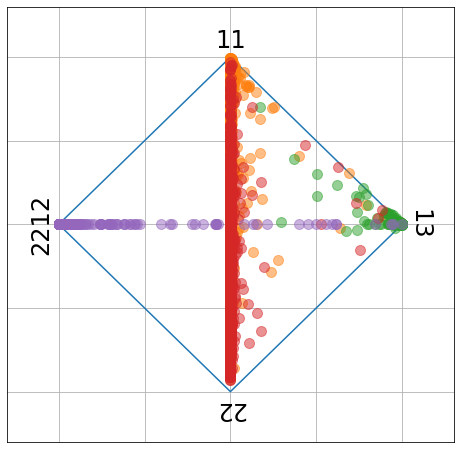

In [22]:
# For the Test set
labels, softmax = run_test(model,test_loader,100,device=device)
print('Test set accuracy mean',np.mean(labels==np.argmax(softmax,axis=1)),
      'std',np.std(labels==np.argmax(softmax,axis=1)))
plot_confusion_matrix(labels,np.argmax(softmax,axis=1),test_data.classes)
plot_softmax(labels,softmax,test_data.classes)